In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy; spacy.load('en')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import seaborn as sns

In [2]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
from nltk import stem
stop_words = stopwords.words('english')

In [3]:
common_words =['from','subject', 'would','also','could','make','still','think','however','may','zzz','know']
stop_words.extend(word for word in common_words if word not in stop_words)
# print(stop_words)

In [4]:
pwd

'/Users/crystal/Downloads/ASI/Senti Analysis & Topic Modeling'

# ASRS data

In [5]:
# # Import ASRS data
# asrs = pd.read_csv("asrs_new_report_1.csv")
# new_report = asrs['new report 1']
# report_1 = asrs['report 1']
# report_1 = report_1.apply(lambda x: x.lower())

In [6]:
# Emergency
asrs = pd.read_csv("emergency_new_report_1.csv")
new_report = asrs['new report 1']
report_1 = asrs['report 1']
report_1 = report_1.apply(lambda x: x.lower())

In [7]:
asrs.columns[100:]

Index(['assessments', 'assessments.1', 'report 1', 'report 1.1', 'report 2',
       'report 2.1', 'airspace_abre_2_2.1', 'new report 1'],
      dtype='object')

In [8]:
len(new_report),len(report_1)

(5646, 5646)

In [9]:
# tokenize each sentence into a list of words, removing punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(new_report))

In [10]:
#Stemming
wnl = stem.WordNetLemmatizer()
data_words = [[wnl.lemmatize(word) for word in sentence] for sentence in data_words]

In [ ]:
#create bag-of-words for each narrative
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])
print(bigram_mod[data_words[0]])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

In [ ]:
# # Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## find the optimal number of topics for LDA

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=8, limit=30, step=2)

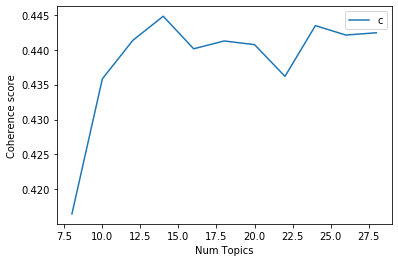

In [25]:
# Show graph
limit=30; start=8; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3628
Num Topics = 3  has Coherence Value of 0.3802
Num Topics = 4  has Coherence Value of 0.4037
Num Topics = 5  has Coherence Value of 0.3913
Num Topics = 6  has Coherence Value of 0.4047
Num Topics = 7  has Coherence Value of 0.4201
Num Topics = 8  has Coherence Value of 0.408
Num Topics = 9  has Coherence Value of 0.423
Num Topics = 10  has Coherence Value of 0.4344
Num Topics = 11  has Coherence Value of 0.4312
Num Topics = 12  has Coherence Value of 0.4294
Num Topics = 13  has Coherence Value of 0.4416
Num Topics = 14  has Coherence Value of 0.4477
Num Topics = 15  has Coherence Value of 0.4553
Num Topics = 16  has Coherence Value of 0.4451
Num Topics = 17  has Coherence Value of 0.4475


In [ ]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

## Finding topics Using LDA model

In [33]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [34]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.073*"aircraft" + 0.018*"damage" + 0.013*"right" + 0.012*"leave" + '
  '0.012*"cause" + 0.011*"brake" + 0.010*"stop" + 0.010*"reporter" + '
  '0.009*"wing" + 0.009*"side"'),
 (1,
  '0.039*"tell" + 0.036*"call" + 0.036*"ask" + 0.035*"say" + '
  '0.031*"controller" + 0.030*"clearance" + 0.023*"give" + 0.021*"clear" + '
  '0.021*"tower" + 0.017*"time"'),
 (2,
  '0.244*"runway" + 0.057*"taxi" + 0.031*"land" + 0.026*"ground" + '
  '0.023*"line" + 0.022*"taxiway" + 0.021*"clear" + 0.018*"landing" + '
  '0.018*"end" + 0.018*"takeoff"'),
 (3,
  '0.109*"aircraft" + 0.055*"traffic" + 0.029*"turn" + 0.020*"pattern" + '
  '0.020*"see" + 0.020*"mile" + 0.019*"final" + 0.016*"position" + '
  '0.016*"call" + 0.015*"report"'),
 (4,
  '0.129*"flight" + 0.062*"approach" + 0.047*"visual" + 0.042*"rule" + '
  '0.034*"instrument" + 0.022*"system" + 0.018*"plan" + 0.013*"condition" + '
  '0.013*"area" + 0.012*"weather"'),
 (5,
  '0.064*"engine" + 0.041*"fuel" + 0.024*"flight" + 0.022*"emergency" + 

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.118951987364732

Coherence Score:  0.463421017889191


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.021409 -0.004508       1        1  15.184697
1     -0.226905 -0.009282       2        1  14.173153
3     -0.083734  0.176936       3        1  11.993976
9     -0.134055  0.147258       4        1  11.513133
8     -0.046344 -0.101070       5        1  10.904894
7     -0.160233 -0.290212       6        1   9.678289
0      0.092083  0.120652       7        1   9.035563
2      0.075663  0.153218       8        1   7.413732
5      0.189639 -0.153714       9        1   6.387633
6      0.315294 -0.039279      10        1   3.714922, topic_info=    Category           Freq      Term          Total  loglift  logprob
203  Default  101041.000000    runway  101041.000000  30.0000  30.0000
26   Default   82380.000000      foot   82380.000000  29.0000  29.0000
24   Default  119660.000000    flight  119660.000000  28.0000  28.0000
99   Default  109853.000000  aircraft  109853.000000  27.0000  27.0000
186  Default   47682.000000     pilot   47682.000000  26.0000  26.0000
..       ...            ...       ...            ...      ...      ...
3    Topic10    1516.826416   attempt    7330.764648   1.7174  -4.9173
528  Topic10    1331.879761      fail    5856.330566   1.8119  -5.0474
214  Topic10    1358.479858    switch    7529.126953   1.5804  -5.0276
151  Topic10    1251.879761     final   18365.265625   0.6070  -5.1093
266  Topic10    1267.723755  approach   65691.476562  -0.6549  -5.0967

[663 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
98        1  0.157408   able
98        2  0.007782   able
98        3  0.010512   able
98        4  0.143483   able
98        5  0.566696   able
...     ...       ...    ...
513      10  0.017078   work
961       2  0.942837  wrong
961       6  0.056989  wrong
1292      6  0.999363   year
2110      2  0.997066   yell

[1245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 10, 9, 8, 1, 3, 6, 7])

In [75]:
pyLDAvis.save_html(vis, 'lda.html')

In [16]:
## Finding topics Using LDA Mallet Model

# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# # Show Topics
# pprint(ldamallet.show_topics(formatted=False))

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

## Finding the dominant topic in each narrative

In [18]:
# list(enumerate(lda_model[corpus[0:2]]))[1][1][1]

In [52]:
sent_topics_df = pd.DataFrame()
for i, row in enumerate(lda_model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)

In [53]:
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df = pd.concat([sent_topics_df, report_1], axis=1)

# Format
df_dominant_topic = sent_topics_df.reset_index()
df_dominant_topic.columns = ['Narrative_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Narrative_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2221,"foot, altitude, traffic, control, air, level, ...",today flying at 9000 ft near msv on an ifr flt...
1,1,4.0,0.5255,"flight, approach, visual, rule, instrument, sy...",inadvertent penetration of r6601 (fort a.p. hi...
2,2,3.0,0.3981,"aircraft, traffic, turn, pattern, see, mile, f...",i tuned in the asos and received field info wi...
3,3,6.0,0.3196,"gear, landing, student, instructor, flap, land...",we took off and i noticed the gear unsafe ligh...
4,4,1.0,0.4517,"tell, call, ask, say, controller, clearance, g...",i requested a twr enrte clrnc from vny to lgb....
5,5,4.0,0.2308,"flight, approach, visual, rule, instrument, sy...",after the run-up; i reviewed the dep proc for ...
6,6,5.0,0.3141,"engine, fuel, flight, emergency, check, mainte...",a full rwy and diagnostic indications chked pr...
7,7,2.0,0.4478,"runway, taxi, land, ground, line, taxiway, cle...",i was clred to taxi to rwy 4 at hut from a ram...
8,8,8.0,0.3237,"go, land, get, plane, fly, time, see, airport,...",my family and i had dinner at caldwell and wer...
9,9,8.0,0.2558,"go, land, get, plane, fly, time, see, airport,...",was practicing touch and goes. winds 310 degs ...


## Find the most representative document for each topic

In [54]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Narrative_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
columnsTitles = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','Narrative_No','Text']
sent_topics_sorteddf = sent_topics_sorteddf.reindex(columns=columnsTitles)
# Show
sent_topics_sorteddf.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Narrative_No,Text
0,0.0,0.6492,"aircraft, damage, right, leave, cause, brake, ...",45406,wing strut end fitting was loose. loose strut ...
1,1.0,0.7245,"tell, call, ask, say, controller, clearance, g...",12148,i obtained the clrnc from lax clrnc delivery a...
2,2.0,0.6772,"runway, taxi, land, ground, line, taxiway, cle...",34031,landed rwy 17r; turned onto txwy b8; told to h...
3,3.0,0.7002,"aircraft, traffic, turn, pattern, see, mile, f...",27807,i entered a standard l upwind for rwy 27 makin...
4,4.0,0.7867,"flight, approach, visual, rule, instrument, sy...",51468,wx was rpted as 900 ft ceiling and 10 mi visib...
5,5.0,0.6408,"engine, fuel, flight, emergency, check, mainte...",394,upon tkof roll; r eng suffered fuel starvation...
6,6.0,0.6351,"gear, landing, student, instructor, flap, land...",21545,after takeoff; the landing gear did not retrac...
7,7.0,0.5748,"pilot, fly, time, use, administration, day, pa...",11725,commercially available wx/planning has always ...
8,8.0,0.6215,"go, land, get, plane, fly, time, see, airport,...",34029,3 plts arrived at the launch field to fly a pa...
9,9.0,0.7797,"foot, altitude, traffic, control, air, level, ...",50429,while dep teb on the teb 5 dep; rwy 24; the si...


## Topic distribution across documents

In [62]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[['Dominant_Topic', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Narratives', 'Perc_Narratives']

# Show
df_dominant_topics.reset_index(drop=True, inplace=True)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Narratives,Perc_Narratives
0,0.0,"aircraft, damage, right, leave, cause, brake, ...",5697,0.1087
1,1.0,"tell, call, ask, say, controller, clearance, g...",6620,0.1263
2,2.0,"runway, taxi, land, ground, line, taxiway, cle...",4220,0.0805
3,3.0,"aircraft, traffic, turn, pattern, see, mile, f...",7430,0.1418
4,4.0,"flight, approach, visual, rule, instrument, sy...",9745,0.1859
5,5.0,"engine, fuel, flight, emergency, check, mainte...",4369,0.0834
6,6.0,"gear, landing, student, instructor, flap, land...",1567,0.0299
7,7.0,"pilot, fly, time, use, administration, day, pa...",2134,0.0407
8,8.0,"go, land, get, plane, fly, time, see, airport,...",3462,0.0661
9,9.0,"foot, altitude, traffic, control, air, level, ...",7169,0.1368


### Save results to Excel

In [80]:
topics = pd.DataFrame(lda_model.print_topics()) 
topics.columns = ['Topic_Number','Topic_Keywords']

In [81]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('topic_model.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
topics.to_excel(writer, sheet_name='topics', index=False)
df_dominant_topic.to_excel(writer, sheet_name='topics_for_narratives', index=False)
sent_topics_sorteddf.to_excel(writer, sheet_name='representative_narratives', index=False)
df_dominant_topics.to_excel(writer, sheet_name='topic_distributions', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Topic Pattern across Years & Assessments

In [244]:
# find top 3 dominant topics for each narrative
topics_1 = pd.DataFrame()
topics_2 = pd.DataFrame()
topics_3 = pd.DataFrame()
for i, row in enumerate(lda_model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic     
                topics_1 = topics_1.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            elif j == 1:
                topics_2 = topics_2.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            elif j == 2:
                topics_3 = topics_3.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
# combine three topics               
top_3_topics = pd.concat([topics_1,topics_2,topics_3], axis=1)

#add report text
report_1 = asrs['report 1'].apply(lambda x: x.lower())
#add assessments.1 and year columns
top_3_topics_for_slicing = pd.concat([asrs[['assessments.1','year']], report_1, top_3_topics], axis=1)
top_3_topics_for_slicing.columns = ['assessments.1','year','report 1','topic_1', 'perc_1','topic_2', 'perc_2','topic_3', 'perc_3']
top_3_topics_for_slicing.tail()

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15,19,20,28,33,44,51,53,54,55,56,66,91) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,assessments.1,year,report 1,topic_1,perc_1,topic_2,perc_2,topic_3,perc_3
52408,Human Factors,1995,i do not know; nor did the company inform me; ...,7.0,0.3514,1.0,0.3014,5.0,0.1313
52409,Human Factors,1995,what really caused prob was lack of attn by gn...,2.0,0.2947,7.0,0.1745,4.0,0.1162
52410,Human Factors,1995,i was on a vfr flt coming inbound for a lndg. ...,1.0,0.2422,4.0,0.2225,8.0,0.2006
52411,Aircraft,1995,after tkof from my fifth (and last) freight st...,0.0,0.2330,6.0,0.1551,7.0,0.1414
52412,Aircraft,1995,on may/xx/95 i ferried an airplane from iowa t...,7.0,0.2513,1.0,0.1525,3.0,0.1418


In [245]:
#delete abnormal years
top_3_topics_for_slicing = top_3_topics_for_slicing[(top_3_topics_for_slicing.year != 20) & (top_3_topics_for_slicing.year != 1988)
                              & (top_3_topics_for_slicing.year != 1989)& (top_3_topics_for_slicing.year != 1990)
                              & (top_3_topics_for_slicing.year != 1991)& (top_3_topics_for_slicing.year != 1993)]

In [250]:
# reclassify assessments into human_factor and non_human_factor
top_3_topics_for_slicing.loc[top_3_topics_for_slicing['assessments.1'] == 'Human Factors', 'assessments_binary'] = "human_factor"
top_3_topics_for_slicing.loc[top_3_topics_for_slicing['assessments.1'] != 'Human Factors', 'assessments_binary'] = "non_human_factor"

In [251]:
#find the topic distribution in human_facor and non_human_factor groups
topics_distribution_across_assessments = pd.DataFrame()
assessment_list = list(top_3_topics_for_slicing['assessments_binary'].unique())
for assessment in assessment_list:
    topic_weight = top_3_topics_for_slicing[top_3_topics_for_slicing['assessments_binary'] == assessment]
    topics_distribution_across_assessments[assessment] = sum(topic_weight.groupby([x])['perc_1'].mean()*topic_weight.groupby([x])['assessments.1'].count() for x in ["topic_1","topic_2","topic_3"])

,human_factor,non_human_factor
topic_1,,
0.0,1844.685400,2183.104956
1.0,5912.584601,2257.828338
2.0,2811.297200,1109.546500
3.0,4231.789301,1737.597305
4.0,4737.693202,2604.463404
5.0,843.837700,1814.560527
6.0,560.601500,823.794986
7.0,2887.235401,1541.364435
8.0,3378.235801,2390.136179


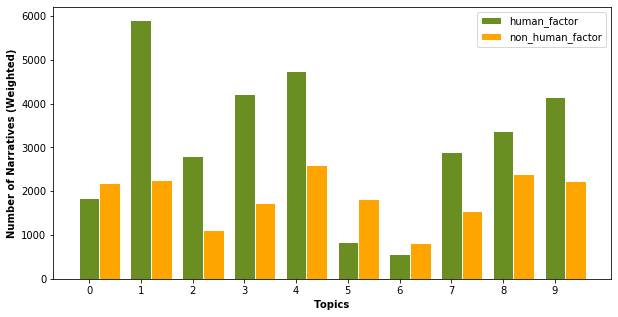

In [282]:
fig= plt.figure(figsize = (10,5))
# set width of bar
barWidth = 0.4

# Set position of bar on X axis
r1 = np.arange(len(topics_distribution_across_assessments['human_factor']))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1,topics_distribution_across_assessments['human_factor'], color='olivedrab', width=barWidth, edgecolor='white', label='human_factor')
plt.bar(r2,topics_distribution_across_assessments['non_human_factor'], color='orange', width=barWidth, edgecolor='white', label='non_human_factor')

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold')
plt.ylabel('Number of Narratives (Weighted)', fontweight='bold')
plt.xticks(topics_distribution_across_assessments.index )
# ['aircraft',"communication",'runway','traffic',"IFR/ VFR","maintenance","student","administration","airport","air traffic control"]
# Create legend & Show graphic
plt.legend()
plt.show()

In [290]:
topic_table = pd.DataFrame(list(topics_distribution_across_assessments.index),
              ['aircraft',"communication",'runway','traffic',"IFR/ VFR","maintenance","student","administration","airport","air traffic control"])
topic_table = topic_table.reset_index()
topic_table.columns = ['topic','topic_number']
topic_table[['topic_number','topic']]

,topic_number,topic
0,0.0,aircraft
1,1.0,communication
2,2.0,runway
3,3.0,traffic
4,4.0,IFR/ VFR
5,5.0,maintenance
6,6.0,student
7,7.0,administration
8,8.0,airport
9,9.0,air traffic control


In [284]:
# find the topic distribution across years
topics_distribution_across_years = pd.DataFrame()
year_list = list(top_3_topics_for_slicing['year'].unique())
year_list.sort() 
for year in year_list:
    topic_weight = top_3_topics_for_slicing[top_3_topics_for_slicing['year'] == year]
    topics_distribution_across_years[year] = sum(topic_weight.groupby([x])['perc_1'].mean()*topic_weight.groupby([x])['assessments.1'].count() for x in ["topic_1","topic_2","topic_3"])
    

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
topic_1,,,,,,,,,,,,,,,,,,,,,
0.0,217.012604,241.536138,210.887406,197.045947,160.021109,178.750257,140.006309,159.894427,154.503926,174.595002,...,127.873270,153.974310,137.700455,124.856234,134.208086,164.630038,164.788902,155.547700,161.916800,79.682425
1.0,372.510394,574.084171,432.814952,425.174310,312.925805,491.781131,434.737246,434.199060,475.317184,602.260820,...,190.562375,211.338472,227.853996,179.857900,201.530894,273.090644,275.264371,249.345848,210.260669,107.142026
2.0,190.997877,245.584367,174.360583,178.287365,143.413305,189.595910,203.711641,217.118078,289.528820,263.500626,...,89.708176,108.668894,110.629004,82.277800,91.923000,133.709646,132.940711,134.676488,125.572700,61.958500
3.0,280.538053,345.381264,278.654397,286.242122,223.896235,279.617236,255.254555,279.622318,312.593485,366.088448,...,145.368038,172.897982,191.590766,156.661170,191.864052,251.126091,273.631421,273.062508,236.730208,118.461644
4.0,340.538749,524.092267,391.499346,390.400433,287.722549,424.346929,341.819031,395.910419,346.778922,576.477054,...,180.400684,204.375259,218.498000,169.798400,196.478872,254.547031,241.730700,213.220100,211.035466,95.921611
5.0,151.981291,155.978252,128.550353,118.156571,107.398137,111.834499,90.864646,91.765027,90.891793,102.523106,...,106.958600,111.468343,116.390867,105.871513,87.943383,120.391988,106.972900,97.285300,89.611400,36.589500
6.0,76.354274,79.556318,78.161051,71.267059,64.491296,56.062411,41.497400,54.303677,66.401676,63.265745,...,40.970200,45.622700,45.691218,41.042000,47.051000,54.900085,52.907600,51.979100,55.483300,28.693600
7.0,207.126700,340.992716,227.457357,222.085991,167.942815,230.108563,194.972311,235.631738,200.454687,318.431884,...,114.153943,132.674920,143.283400,116.410428,128.728806,160.036940,152.969566,129.322410,110.790500,56.310322
8.0,319.873516,417.458777,317.886600,292.850215,216.241550,285.452324,226.834439,260.373639,270.510975,310.386500,...,164.277013,174.785462,188.748393,170.164589,161.411388,196.850109,214.908742,207.216200,223.319000,95.894772


Text(0, 0.5, 'Number of Narratives (Weighted)')

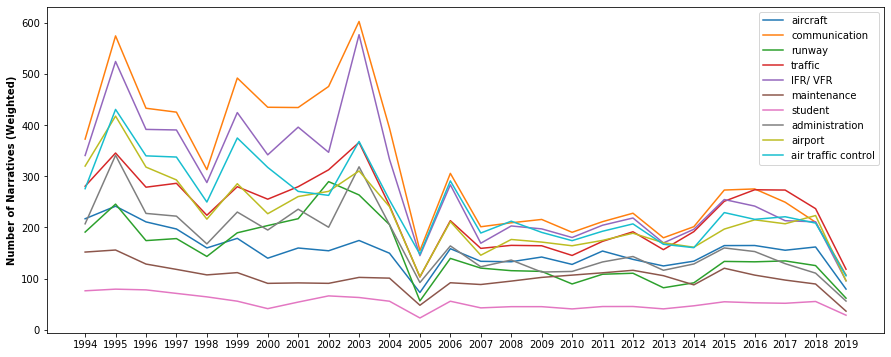

In [286]:
fig= plt.figure(figsize = (15,6))
topic_list = topics_distribution_across_years.index
for topic in topic_list:
    plt.plot(topics_distribution_across_years.transpose()[topic])
plt.xticks(year_list)
plt.legend(['aircraft',"communication",'runway','traffic',"IFR/ VFR","maintenance","student","administration","airport","air traffic control"])
plt.ylabel('Number of Narratives (Weighted)', fontweight='bold')

* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

- Classify based on human/ non-human factors
- Emergency (other keywords)
- Word count based on Ntsb dataset
- Remove common words